In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import imageio
import numpy as np
import flowermodel.find_blobs as fb
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
!flowermodel framecount --filename ../data/movies/41586_2019_1429_MOESM4_ESM.mov

271


In [57]:
!mkdir pbslogs

In [62]:
%%writefile blob.pbs
#!/bin/bash
#PBS -l nodes=1:ppn=2
#PBS -l walltime=0:10:00
#PBS -l mem=4GB
#PBS -q batch
#PBS -N blob
#PBS -t 0-270
#PBS -o pbslogs/$PBS_JOBNAME.o
#PBS -e pbslogs/$PBS_JOBNAME.e

cd $PBS_O_WORKDIR
FILE="../data/movies/41586_2019_1429_MOESM4_ESM.mov"
. /projects/chuang-lab/jnh/miniconda3/etc/profile.d/conda.sh
conda activate flower
flowermodel blob --filename $FILE --blob-index $PBS_ARRAYID

Overwriting blob.pbs


In [63]:
!qsub blob.pbs

10506235[].helix-master


In [83]:
import pandas as pd
import glob
moviefile = '41586_2019_1429_MOESM4_ESM.mov'
files = glob.glob('../data/blobs/{:s}/blob*.csv'.format(moviefile))
blobs = [pd.read_csv(file) for file in files]
blobs = pd.concat(blobs).sort_values(['frame', 'color', 'x', 'y']).reset_index(drop=True)

In [84]:
filename = '../data/movies/{:s}'.format(moviefile)
vid = imageio.get_reader(filename,  'ffmpeg')

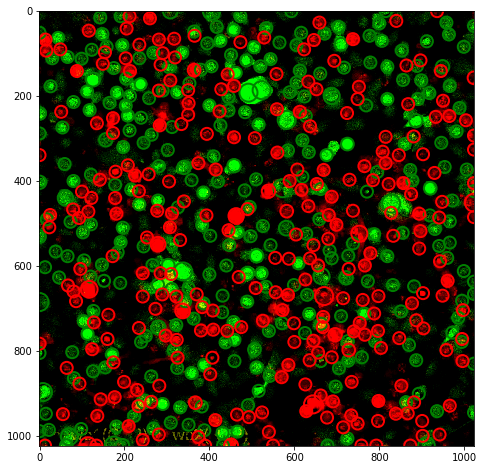

In [92]:
from flowermodel import plotting  
img_idx = 0
plotting.plot_blob_overlay(vid, img_idx, blobs)    

# Scratch

In [45]:
blobs.to_csv(os.path.join(outputdir, 'blob{:d}.csv'.format(blob_idx)), index=False)

In [44]:
import os
from flowermodel import util
blob_idx = 3
filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
outputdir = os.path.join('../data/blobs/', os.path.basename(filename))
util.mkdir_if_not_exist(outputdir)

blobs = fb.get_allframes_blobs(filename, min_idx=blob_idx, max_idx=blob_idx+1)
blobs.to_csv(os.path.join(outputdir, 'blob{:d}.csv'.format(blob_idx)))




  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:22<00:00, 22.05s/it]


In [38]:
# filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
# allblobs = fb.get_allframes_blobs(filename)

In [50]:
%%bash
flowermodel blob --filename ../data/movies/41586_2019_1429_MOESM4_ESM.mov --blob-index 2 

100%|██████████| 1/1 [00:26<00:00, 26.45s/it]


In [2]:
# from skimage.restoration import inpaint_biharmonic, denoise_wavelet
# from skimage.morphology import disk, square
# from skimage.filters import rank
# from skimage.util import img_as_ubyte
# from skimage.exposure import equalize_hist, equalize_adapthist
# from skimage.feature import blob_dog, blob_log, blob_doh

def remove_text(img):
    th = threshold_otsu(img[:, :, 2])
    mask = img[:, :, 2] > th
    newimg = img.copy()
    newimg[:, :, 2] = 0
    newimg = inpaint_biharmonic(newimg, mask, multichannel=True)
    return newimg

def get_image(vid, img_idx):
    img = vid.get_data(img_idx)
    img = remove_text(img)
    # img = img[35:-42, :, :] # remove annotations on the image
    return img

In [3]:
filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
vid = imageio.get_reader(filename,  'ffmpeg')

In [4]:
vid.count_frames()

271

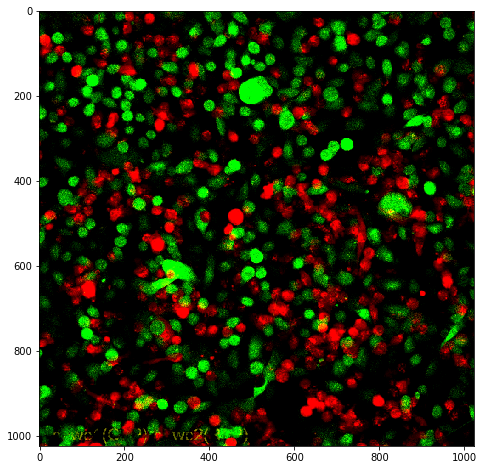

In [5]:
img_idx = 0
img = get_image(vid, img_idx)

plt.figure(figsize=(8,8))
plt.imshow(img)

In [50]:
import pandas as pd

# blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
# blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
# blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

def get_blobs(imgray, min_sigma=3, max_sigma=10, num_sigma=10, threshold=.1, opening_disk_radius = 5):
#     imgray_opened = opening((imgray * 256).astype(int), disk(opening_disk_radius))/256     
    blobs = blob_log(imgray, max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=num_sigma, threshold=threshold)
    blobs = pd.DataFrame(blobs, columns=['x', 'y', 'radius'])
    blobs['radius'] *= np.sqrt(2)
    return blobs

def plot_blobs(blobs, ax, color='r'):
    for y, x, r in blobs:
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)
#         ax.set_axis_off()


def get_frame_blobs(img, min_sigma=10, max_sigma=15, num_sigma=10, threshold=.1):
    '''
    This function finds all the blobs within the image and assigns them their corresponding color (GFP/RFP)
    '''
    blobs_r = get_blobs(img[:, :, 0], max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=num_sigma, threshold=threshold)
    blobs_g = get_blobs(img[:, :, 1], max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=num_sigma, threshold=threshold)   

    blobs_r['color'] = 'r'
    blobs_g['color'] = 'g'

    blobs = pd.concat([blobs_r, blobs_g])
    blobs.reset_index(drop=True, inplace=True)
    blobs[['x', 'y']] = blobs[['x', 'y']].astype(int)
    return blobs


filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
vid = imageio.get_reader(filename,  'ffmpeg')
img_idx = 100
img = get_image(vid, img_idx)
blobs = get_frame_blobs(img, min_sigma=10, max_sigma=15, num_sigma=10, threshold=.1)
blobs['frame'] = img_idx

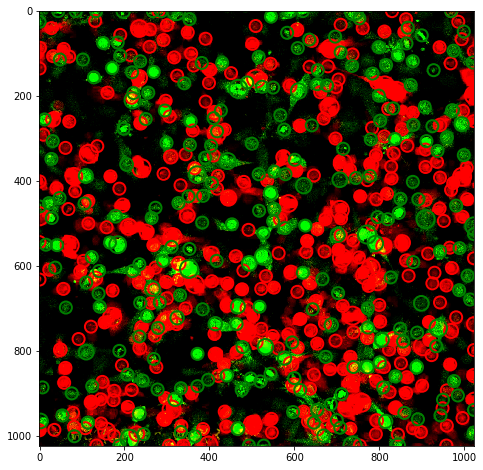

In [48]:
# blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
# blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
# blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)




def get_blobs(imgray, min_sigma=3, max_sigma=10, num_sigma=10, threshold=.1, opening_disk_radius = 5):
#     imgray_opened = opening((imgray * 256).astype(int), disk(opening_disk_radius))/256     
    blobs = blob_log(imgray, max_sigma=max_sigma, min_sigma=min_sigma,
                     num_sigma=num_sigma, threshold=threshold)
    blobs[:, 2] *= np.sqrt(2)
    return blobs

def plot_blobs(blobs, ax, color='r'):
    for y, x, r in blobs:
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)
#         ax.set_axis_off()

_, ax = plt.subplots(1, 1, figsize=(8,8))
img_idx = 100
img = get_image(vid, img_idx)

ax.imshow(img)

blobs_r = get_blobs(img[:, :, 0], min_sigma=10, max_sigma=15, num_sigma=10, threshold=.1, opening_disk_radius = 5)
blobs_g = get_blobs(img[:, :, 1], min_sigma=10, max_sigma=15, num_sigma=10, threshold=.1, opening_disk_radius = 5)

plot_blobs(blobs_r, ax, color='red')
plot_blobs(blobs_g, ax, color='green')

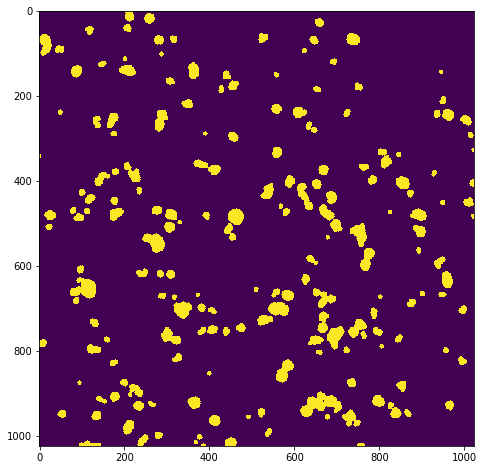

In [140]:
plt.figure(figsize=(8,8))
th = threshold_otsu(imgray_opened)
plt.imshow(imgray_opened > th)

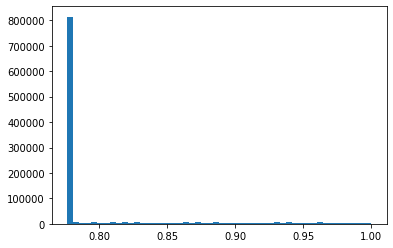

In [139]:
plt.hist(equalize_hist(imgray_opened.flatten()), 50);

In [73]:
imgray_denoised = denoise_wavelet(imgray, multichannel=False)

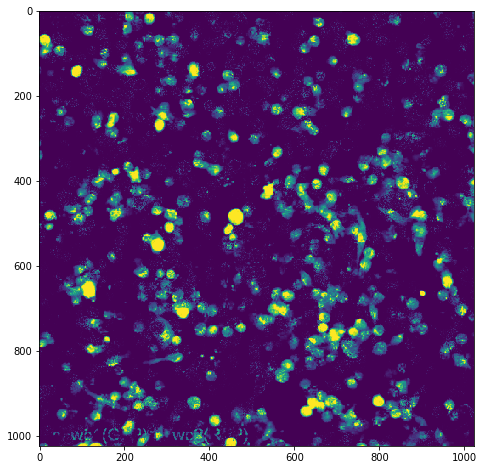

In [74]:
plt.figure(figsize=(8,8))
plt.imshow(imgray_denoised)

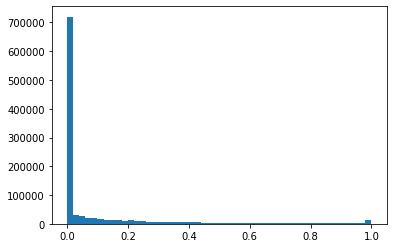

In [64]:
plt.hist(imgray.flatten(), 50);

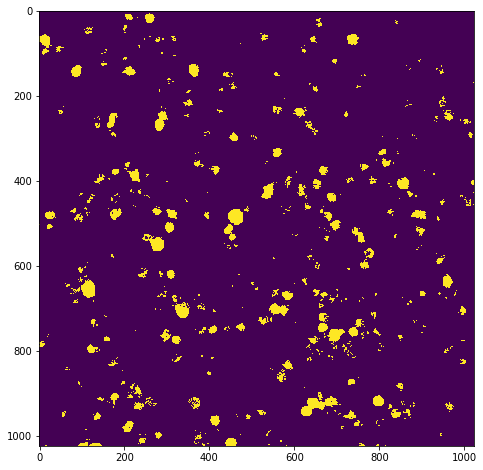

In [68]:
plt.figure(figsize=(8,8))
plt.imshow(imgray > 0.6)

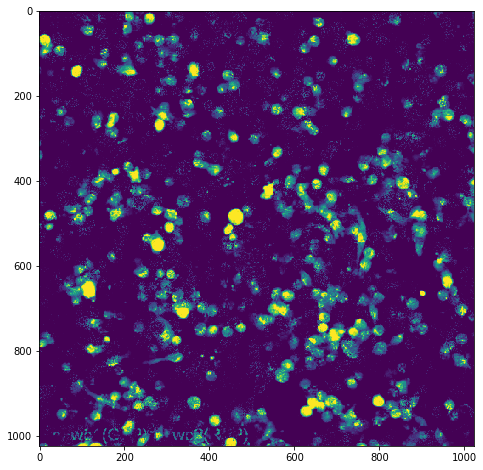

In [120]:
imgray = img[:, :, 0]
imgray = (imgray * 256).astype(int)
plt.figure(figsize=(8,8))
plt.imshow(imgray)

In [126]:

# selem = square(300)
# img_eq = rank.equalize(img_as_ubyte(imgray), selem=selem)
img_eq = equalize_hist(imgray)

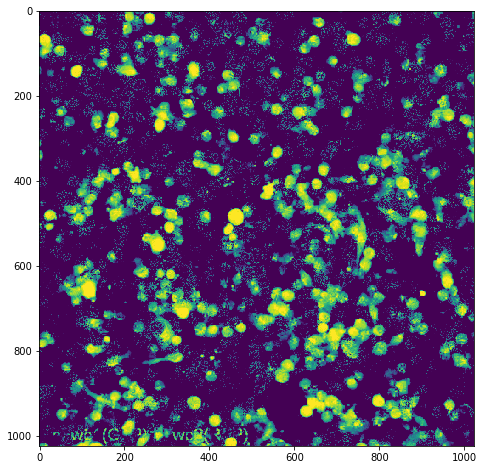

In [127]:
plt.figure(figsize=(8,8))
plt.imshow(img_eq)

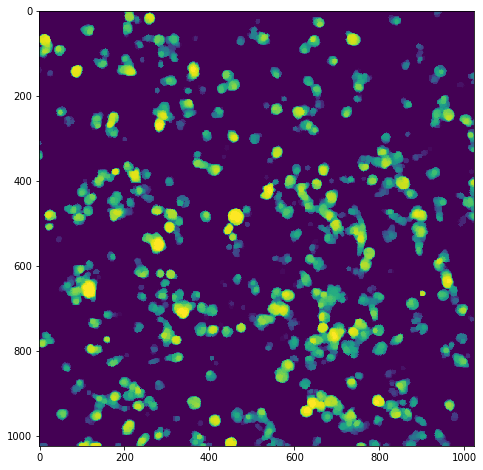

In [130]:
from skimage.morphology import opening

plt.figure(figsize=(8,8))
plt.imshow(opening(img_eq, disk(5)))

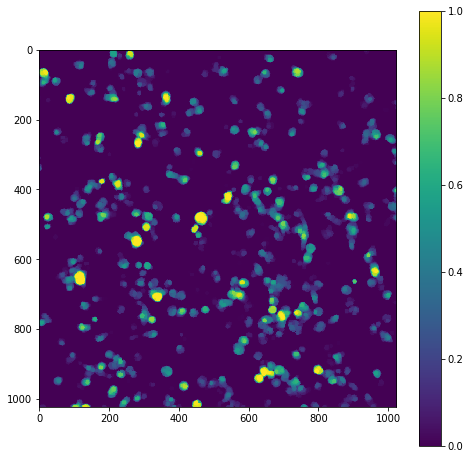

In [199]:
plt.figure(figsize=(8,8))
imgray_opened = opening(imgray, disk(5))
plt.imshow(imgray_opened/256)
plt.colorbar()

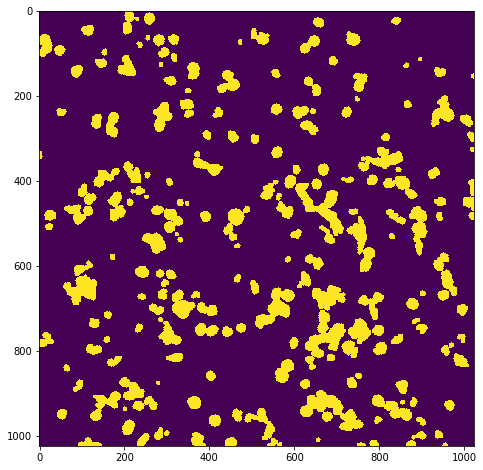

In [200]:
plt.figure(figsize=(8,8))
plt.imshow(imgray_opened/256 > 0.1)

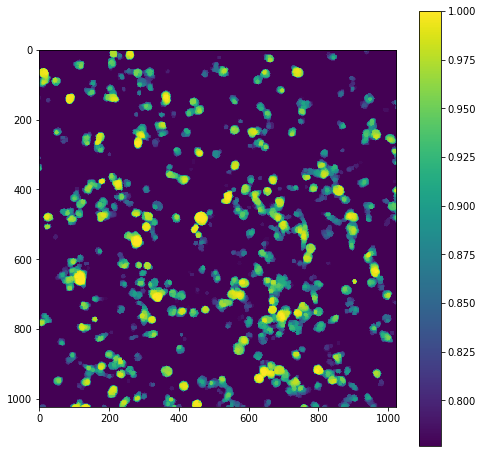

In [156]:
plt.figure(figsize=(8,8))
plt.imshow(equalize_hist(imgray_opened)); 

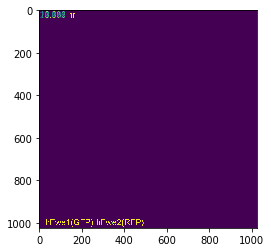

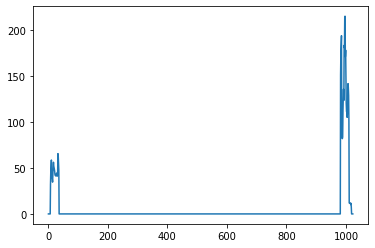

In [41]:
filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
vid = imageio.get_reader(filename,  'ffmpeg')

im = 0
for image in vid.iter_data():
    im += image[:, :, 2] > 200

im = im/vid.count_frames()    
metadata = vid.get_meta_data()

plt.imshow(im);
plt.figure()
plt.plot(im.sum(axis=1))

In [124]:

imsum = im.sum(axis=1)
th = imsum[:imsum.shape[0]//2].max()/2
# imsum = (imsum > th).astype(int)
# plt.plot(imsum)
# imsumdiff = np.diff(imsum)
# plt.plot(imsumdiff)

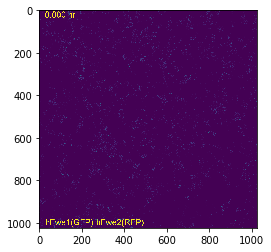

In [125]:
plt.imshow(img[:, :, 2])

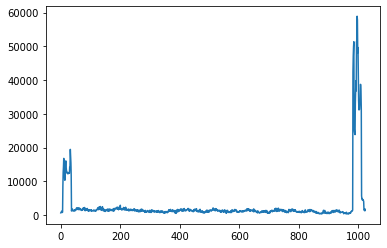

In [116]:
plt.plot(img[:, :, 2].sum(axis=1))

In [41]:
img.shape

(947, 1024, 3)

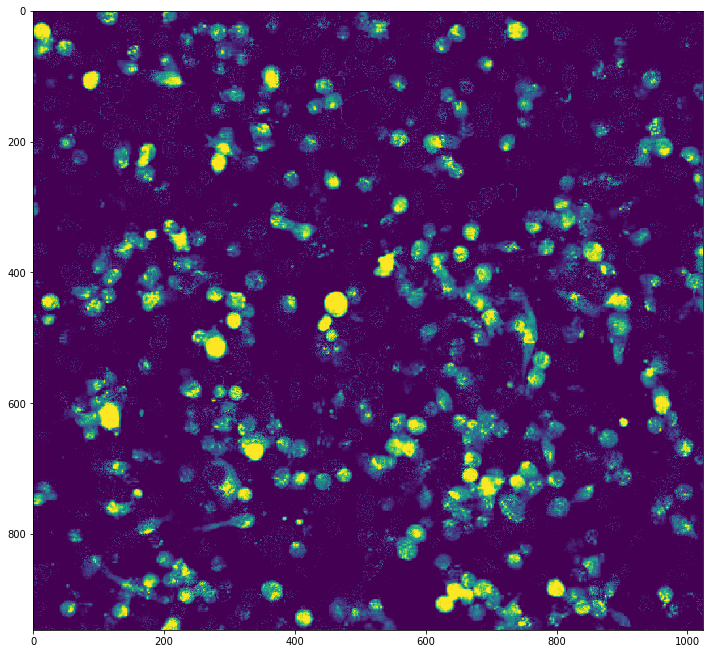

In [43]:
plt.figure(figsize=(12, 12))
plt.imshow(img[:, :, 0])

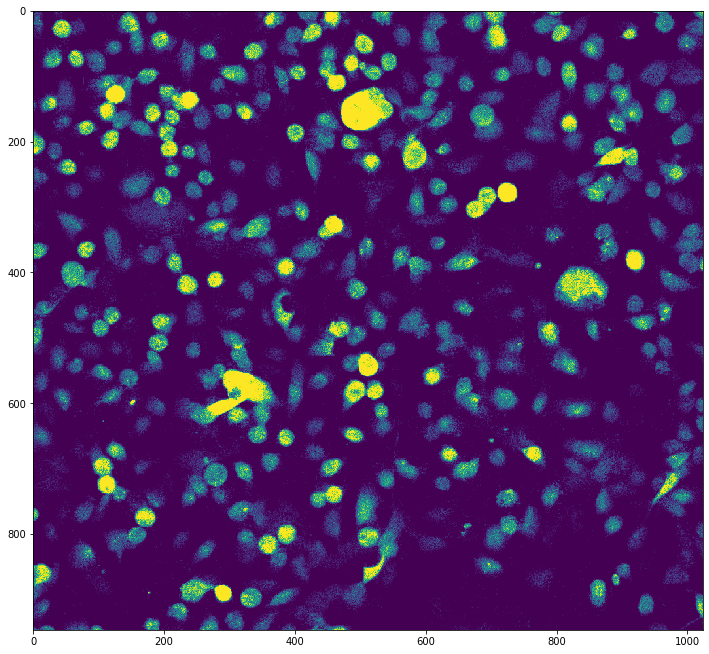

In [44]:
plt.figure(figsize=(12, 12))
plt.imshow(img[:, :, 1])

In [111]:
from scipy.signal import find_peaks
height = imsum[:imsum.shape[0]//2].max()/2
find_peaks(imsum, height=height, width=10)[0]

array([ 32, 997])